In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import accuracy_score
from functools import partial

from moseq2_detectron_extract.io.session import Session, Stream
from moseq2_detectron_extract.proc.proc import prep_raw_frames, clean_frames, get_frame_features, colorize_video

# based on https://sofiadutta.github.io/datascience-ipynbs/pytorch/Denoising-Autoencoder.html

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [44]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, input):
        return input.movedim(2, 0) # input.transpose(2, 0, 1)
        #return input.view(*self.shape)

def moveTo(obj, device):
    if isinstance(obj, tuple):
        return tuple([moveTo(x, device) for x in obj])
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return obj

def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs.float(), device)
            labels = moveTo(labels.float(), device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0:
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0:
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [31]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs.
    This makes it easy to re-use other code"""

    def __init__(self, dataset, num_images=1000):
        self.session = Session(dataset)
        self.first_frame, self.bground_im, self.roi, self.true_depth = self.session.find_roi()

        prep_frames = partial( prep_raw_frames,
                                    bground_im=self.session.bground_im,
                                    roi=self.session.roi,
                                    vmin=0,
                                    vmax=100)
        iterator = self.session.index(range(num_images), chunk_size=num_images)
        iterator.attach_filter(stream=Stream.DEPTH, filterer=prep_frames)
        self.frame_idxs, self.raw_frames = next(iterator)

    def __len__(self):
        return self.raw_frames.shape[0]

    def __getitem__(self, idx):
        image = self.raw_frames[idx]
        #print(image.shape)
        image = image[:, :, None].transpose(2, 0, 1)
        #print(self.raw_frames[idx].shape, image.shape)
        return image, image

In [55]:
train_data = AutoEncodeDataset(r"H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Abraira_Lab\Spinal_Cord_Injury-C57BL6\11_animal_subset\session_20200814144734.tar.gz", num_images=10000)
test_data = AutoEncodeDataset(r"H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Dulin_Lab\DREADDs Cohort- Ashley Tucker\Week 9 Post Transplantation Post CNO\session_20220819105327.tar.gz")
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

In [56]:
normal = torch.distributions.Normal(0, 0.5)

def addNoise(x, device='cpu'):
    """
    We will use this helper function to add noise to some data. 
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on. 
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

class AdditiveGausNoise(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        #every PyTorch Module object has a self.training boolean which can be used 
        #to check if we are in training (True) or evaluation (False) mode. 
        if self.training:
             return addNoise(x, device=device)
        else:
            return x

In [57]:
def showEncodeDecode(encode_decode, x):
    encode_decode = encode_decode.cpu()
    with torch.no_grad():
        x_recon = encode_decode(x.cpu())

    print(x.shape, x_recon.shape)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0, 0])
    axarr[1].imshow(x_recon.numpy()[0,0])

In [65]:
def build_network(channels=1):
    # dnauto_encoder_conv_big = nn.Sequential(
    #     AdditiveGausNoise(),
    #     #View(-1, channels, 28, 28),
    #     nn.Conv2d(channels, 2, (3, 3), padding=1), # 1 * 28 *28 to 2 * 28 *28
    #     nn.BatchNorm2d(2),
    #     nn.ReLU(),
    #     nn.Conv2d(2, 2, (3, 3), padding=1),# 2 * 28 *28 to 2 * 28 *28
    #     nn.BatchNorm2d(2),
    #     nn.ReLU(),
    #     nn.Conv2d(2, 2, (3, 3), padding=1),# 2 * 28 *28 to 2 * 28 *28
    #     nn.BatchNorm2d(2),
    #     nn.ReLU(),
    #     nn.Conv2d(2, 2, (3, 3), padding=1) # 2 * 28 *28 to 2 * 28 *28
    # )


    # dnauto_decoder_conv_big = nn.Sequential(
    #     nn.Conv2d(2, 2, (3, 3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    #     nn.BatchNorm2d(2),
    #     nn.ReLU(),
    #     nn.Conv2d(2, 2, (3, 3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    #     nn.BatchNorm2d(2),
    #     nn.ReLU(),
    #     nn.Conv2d(2, 2, (3, 3), padding=1), # 2 * 28 *28 to 2 * 28 *28
    #     nn.BatchNorm2d(2),
    #     nn.ReLU(),
    #     nn.Conv2d(2, channels, (3, 3), padding=1)# 2 * 28 *28  to 1 * 28 * 28
    # )

    # dnauto_encode_decode_conv_big = nn.Sequential(
    #     dnauto_encoder_conv_big,
    #     dnauto_decoder_conv_big
    # )
    #return dnauto_encode_decode_conv_big


    dnauto_encoder_conv_max_big2 = nn.Sequential(
        AdditiveGausNoise(),
        #View(-1,1,28,28),
        nn.Conv2d(channels, 2, (3,3), padding=1), # 1 * 28 *28 to 2 * 28 *28
        nn.BatchNorm2d(2),
        nn.ReLU(),
        AdditiveGausNoise(),
        nn.Conv2d(2, 2, (3,3), padding=1),# 2 * 28 *28 to 2 * 28 *28
        nn.BatchNorm2d(2),
        nn.ReLU(),
        AdditiveGausNoise(),
        nn.Conv2d(2, 8, (3,3), padding=1),# 2 * 28 *28 to 8 * 28 *28
        nn.BatchNorm2d(8),
        nn.ReLU(),
        AdditiveGausNoise(),
        nn.MaxPool2d((2,2))# 8 * 28 *28 to 8 * 14 *14 #2 stride 2 kernel size make the C*W*H//4 or (C,W//2,H//2) shaped
        
    )

    dnauto_decoder_conv_max_big2 = nn.Sequential(
        nn.ConvTranspose2d(8, 8, (2,2), stride=2), # 8 * 14 *14 to 8 * 28 *28
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(8, 2, (3,3), padding=1), # 8 * 28 *28 to 2 * 28 *28
        nn.BatchNorm2d(2),
        nn.ReLU(),
        nn.Conv2d(2, 2, (3,3), padding=1), # 2 * 28 *28 to 2 * 28 *28
        nn.BatchNorm2d(2),
        nn.ReLU(),
        nn.Conv2d(2, channels, (3,3),padding=1)# 2 * 28 *28  to 1 * 28 * 28
    )

    dnauto_encode_decode_conv_max_big2 = nn.Sequential(
        dnauto_encoder_conv_max_big2,
        dnauto_decoder_conv_max_big2
    )
    return dnauto_encode_decode_conv_max_big2

In [66]:
mse_loss = nn.MSELoss()
dnauto_encode_decode_conv_big = build_network()

In [67]:
train_network(dnauto_encode_decode_conv_big, mse_loss, train_loader, val_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\thackray\.conda\envs\moseq-detectron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([128, 1, 244, 249])) that is different to the input size (torch.Size([128, 1, 244, 248])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch:   0%|          | 0/10 [01:41<?, ?it/s]


RuntimeError: The size of tensor a (248) must match the size of tensor b (249) at non-singleton dimension 3

torch.Size([2, 1, 244, 249]) torch.Size([2, 1, 244, 249])
torch.Size([2, 1, 244, 249]) torch.Size([2, 1, 244, 249])


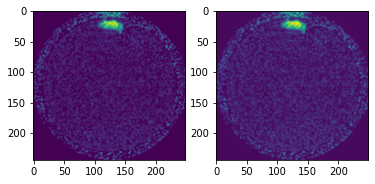

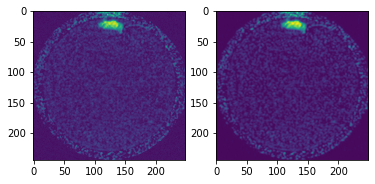

In [ ]:
showEncodeDecode(dnauto_encode_decode_conv_big, torch.tensor(test_data[6]).float())
showEncodeDecode(dnauto_encode_decode_conv_big, addNoise(torch.tensor(test_data[6]).float()))

torch.Size([2, 1, 246, 250]) torch.Size([2, 1, 246, 250])
torch.Size([2, 1, 246, 250]) torch.Size([2, 1, 246, 250])


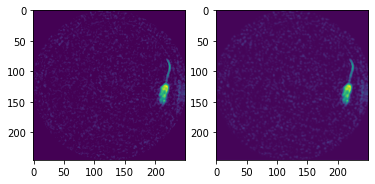

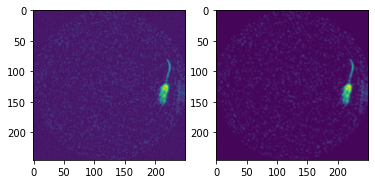

In [ ]:
showEncodeDecode(dnauto_encode_decode_conv_big, torch.tensor(train_data[6]).float())
showEncodeDecode(dnauto_encode_decode_conv_big, addNoise(torch.tensor(train_data[6]).float()))